In [80]:
#####import package ###
import os 
import sys
import numpy as np
import pandas as pd 
from pandas import DataFrame
import sklearn 
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score    ###
from sklearn.metrics import confusion_matrix,matthews_corrcoef,make_scorer,roc_curve, auc,roc_auc_score,precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle  
import warnings
warnings.filterwarnings('ignore')
print(os.getcwd())
##########get data import ###
data = pd.read_csv("./data_1024/final_split/train_data.csv",sep = ",")
data = shuffle(data,random_state = 42)
#print(data.head())
####feature list (clinical and SNP )
def load_data(data):
    feature = data[['sex', 'age',"smoke", 'bmi', 'location', 'rs10007052', 'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976', 'rs473892', 'rs159497', 'rs9296092']]
    #feature = data[['sex', 'age','smoke', 'bmi', 'location']]
    #feature = data[['rs10007052', 'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976', 'rs473892', 'rs159497', 'rs9296092']]
    
    target =  data['label']
    return feature,target

pos_weight = data['label'].value_counts()[0]/data['label'].value_counts()[1]
print(pos_weight)
####### list classify model with default parameter ###
knn = KNeighborsClassifier()
svm = SVC(probability=True,random_state=42)
lr = LogisticRegression(random_state=42,penalty='l1',C=10,max_iter=50,intercept_scaling=10)
tree = DecisionTreeClassifier()
nn = MLPClassifier(hidden_layer_sizes=(8,8,8),random_state = 42)
xgboost = xgb.XGBClassifier(scale_pos_weight=pos_weight,random_state=42,learning_rate=0.05,n_estimators=1000,
                            max_depth = 10,reg_alpha=0.2,subsample=1)
classifier_lst = [knn, lr, svm, tree, nn,xgboost]
classifier_lst_name = ['KNN', 'LR', 'SVM', 'DT', 'MLP','XGboost']

def npv(y_true,y_pred):
    confu = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = confu.ravel()
    NPV = tn/(tn+fn)
    return NPV

def spc(y_true,y_pred):
    confu = confusion_matrix(y_true,y_pred)
    #print(confu,confu.sum())
    tn, fp, fn, tp = confu.ravel()
    TNR = tn/(tn+fp)
    #print(TNR)
    return TNR 

def prcauc(model,fea,tar):
    X = np.array(fea)
    y = np.array(tar)
    aucspr = []
    for train, test in cv.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        #precisions.append(interp(mean_recall, precision,recall))
        pr_auc = auc(recall, precision)
        aucspr.append(pr_auc)
    #print(mean_precision)
    prc_auc_CI = np.percentile(aucspr, 2.5), np.percentile(aucspr, 97.5)
    print("prc_auc_CI",prc_auc_CI)
    return prc_auc_CI

npv_score,spc_score,mcc_score = make_scorer(npv),make_scorer(spc),make_scorer(matthews_corrcoef)
prcauc_score = make_scorer(prcauc)


cv = StratifiedKFold(n_splits=5,random_state=1)
### set StratifiedKFold(CV) =10 
def make_baseline(data,classifier):
    feature,target = load_data(data)
    classifier.fit(feature,target)
    
    acc = cross_val_score(classifier,feature,target,cv =cv)  ## accuracy 
    acc_mean = np.mean(acc) ###
    precisions = cross_val_score(classifier,feature,target,cv =cv,scoring = 'precision')   ### PPV 
    precisions_mean = np.mean(precisions)
    recalls = cross_val_score(classifier,feature,target,cv = cv,scoring = 'recall')  ### sensitity 
    recalls_mean = np.mean(recalls)
    
    print(precisions,recalls)
    #计算PRC AUC
    prc_aucs = prcauc(classifier,feature,target)
    print("PRC AUC:",prc_aucs)
    
    f1s = cross_val_score(classifier,feature,target,cv=cv,scoring='f1')
    f1s_mean = np.mean(f1s)
    mcc= cross_val_score(classifier,feature,target,cv = cv,scoring = mcc_score)
    mcc_mean = np.mean(mcc)
    print("mcc:",mcc,mcc_mean)
    
    spc_value = cross_val_score(classifier,feature,target,cv = cv,scoring = spc_score) # 特异度
    spc_mean = np.mean(spc_value)
    print("spc:",spc_value,spc_mean)
    npv_value = cross_val_score(classifier,feature,target,cv = cv,scoring =npv_score)
    npv_mean = np.mean(npv_value)
    print("npv:",npv_value,npv_mean)
    
    aucs = cross_val_score(classifier,feature,target,cv=cv,scoring='roc_auc') 
    auc_mean = np.mean(aucs)
    
    prc_auc_CI = np.percentile(prc_aucs, 2.5), np.percentile(prc_aucs, 97.5)
    print("prc_auc_CI",prc_auc_CI)
    
    auc_CI = np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)
    ##
    spc_CI = np.percentile(spc_value, 2.5), np.percentile(spc_value, 97.5)
    npv_CI = np.percentile(npv_value,2.5), np.percentile(npv_value, 97.5)
    
    precision_CI = np.percentile(precisions, 2.5), np.percentile(precisions, 97.5)
    f1s_CI = np.percentile(f1s, 2.5), np.percentile(f1s, 97.5)
    acc_CI = np.percentile(acc, 2.5), np.percentile(acc, 97.5)
    recalls_CI = np.percentile(recalls, 2.5), np.percentile(recalls, 97.5)
    mcc_CI = np.percentile(mcc, 2.5), np.percentile(mcc, 97.5)
    return acc_mean,precisions_mean,recalls_mean,f1s_mean,auc_mean,mcc_mean,spc_mean,npv_mean,auc_CI,prc_auc_CI,spc_CI,npv_CI,precision_CI,f1s_CI,acc_CI,recalls_CI,mcc_CI
###### 计算各个模型的不同交叉验证指标
precisions_mean_lst =[]
recalls_mean_lst =[]
f1s_mean_lst,auc_mean_lst,acc_mean_lst,mcc_mean_lst = [],[],[],[]
spc_mean_lst,npv_mean_lst = [],[]
precisions_CI_lst,recalls_CI_lst,f1s_CI_lst,acc_CI_lst,mcc_CI_lst = [],[],[],[],[]
auc_CI_lst,prcauc_CI_list,spc_CI_lst,npv_CI_lst, = [],[],[],[]
for i in classifier_lst:
    acc_mean,precisions_mean,recalls_mean,f1s_mean,auc_mean,mcc_mean,spc_mean,npv_mean,\
    auc_CI,prc_auc_CI,spc_CI,npv_CI,precision_CI,f1s_CI,acc_CI,recalls_CI,mcc_CI = make_baseline(data,i)
    acc_mean_lst.append(acc_mean)
    precisions_mean_lst.append(precisions_mean)
    recalls_mean_lst.append(recalls_mean)
    f1s_mean_lst.append(f1s_mean)
    auc_mean_lst.append(auc_mean)
    
    
    mcc_mean_lst.append(mcc_mean)
    spc_mean_lst.append(spc_mean)
    npv_mean_lst.append(npv_mean)
    
    auc_CI_lst.append(auc_CI)
    prcauc_CI_list.append(prc_auc_CI)
    spc_CI_lst.append(spc_CI)
    npv_CI_lst.append(npv_CI)
    
    precisions_CI_lst.append(precision_CI)
    recalls_CI_lst.append(recalls_CI)
    f1s_CI_lst.append(f1s_CI)
    acc_CI_lst.append(acc_CI)
    mcc_CI_lst.append(mcc_CI)
    
print("acc:",acc_mean_lst)
print("precision:",precisions_mean_lst)
print("recalls:",recalls_mean_lst)
print("mcc",mcc_mean_lst)
print("f1_score:",f1s_mean_lst)
print("auc:",auc_mean_lst)
print("spc:",spc_mean_lst)
print("npv:",npv_mean_lst)
print("auc_CI:",auc_CI_lst)
all_para = {"accuracy":acc_mean_lst,"precision":precisions_mean_lst,
            "recall":recalls_mean_lst,"f1score":f1s_mean_lst,
            "mcc_score":mcc_mean_lst,"aucscore":auc_mean_lst,
            "spc_score":spc_mean_lst,"npv_score":npv_mean_lst,
            "accuracy_CI":acc_CI_lst,"precision_CI":precisions_CI_lst,
            "recall_CI":recalls_CI_lst,"f1_score_CI":f1s_CI_lst,"mcc_CI":mcc_CI_lst,
            "auc_CI":auc_CI_lst,"prc_auc_CI":prcauc_CI_list,"spc_CI":spc_CI_lst,"npv_CI":npv_CI_lst}
result = DataFrame(all_para,index = ['KNN', 'LR', 'SVM', 'DT', 'MLP','XGboost'])
print(result[result.columns[0:7]])

D:\Program File\Anaconda\Jupyter File\宝腾生物实习\10month_copd
0.35517241379310344
[0.83050847 0.92592593 0.86666667 0.87931034 0.9122807 ] [0.84482759 0.86206897 0.89655172 0.87931034 0.89655172]
prc_auc_CI (0.9039095520496225, 0.9415082680822453)
PRC AUC: (0.9039095520496225, 0.9415082680822453)
mcc: [0.37452576 0.63791494 0.53294645 0.52931034 0.63648063] 0.5422356260831904
spc: [0.52380952 0.80952381 0.61904762 0.65       0.75      ] 0.6704761904761904
npv: [0.55       0.68       0.68421053 0.65       0.71428571] 0.6556992481203008
prc_auc_CI (0.904849519950438, 0.9405683001814298)
[0.83050847 0.89655172 0.8358209  0.87301587 0.88135593] [0.84482759 0.89655172 0.96551724 0.94827586 0.89655172]
prc_auc_CI (0.9294876362816875, 0.9768487527270283)
PRC AUC: (0.9294876362816875, 0.9768487527270283)
mcc: [0.37452576 0.61083744 0.54366404 0.60745235 0.55597781] 0.5384914789982316
spc: [0.52380952 0.71428571 0.47619048 0.6        0.65      ] 0.5928571428571429
npv: [0.55       0.71428571 0.8333

In [62]:
result

#result.to_csv("./result_1024/all_feature/allfeature_all_model_evaluation_index_5fold.csv")#使用的特征是全部特征的
#result.to_csv("./result_1024/clincal/clinic_all_model_evaluation_index_5fold.csv")#使用的特征是clinic的
#result.to_csv("./result_1024/feature_snp/snp_all_model_evaluation_index_5fold.csv")#使用的特征是snp的

# plot XGBoost feature_importance

weight: 
 {'age': 784, 'location': 735, 'bmi': 1453, 'sex': 208, 'rs12922394': 232, 'smoke': 148, 'rs2910164': 170, 'rs10007052': 234, 'rs161976': 285, 'rs20541': 201, 'rs473892': 225, 'rs9296092': 88, 'rs8192288': 185, 'rs159497': 346} 

gain: 
 {'age': 1.1168058457280494, 'location': 1.4059966414316458, 'bmi': 0.12197225766667341, 'sex': 0.2633750898627405, 'rs12922394': 0.37961110311215157, 'smoke': 0.313094249878838, 'rs2910164': 0.09962037513598823, 'rs10007052': 0.24488466927240937, 'rs161976': 0.1373968942763598, 'rs20541': 0.14377977201557968, 'rs473892': 0.2243721546831112, 'rs9296092': 0.3011600979988636, 'rs8192288': 0.14027943204689736, 'rs159497': 0.07091218080296915} 

cover: 
 {'age': 7.478753566517862, 'location': 9.283417003020418, 'bmi': 6.060800490922238, 'sex': 4.2344265576923075, 'rs12922394': 5.582279418362068, 'smoke': 5.818092804864867, 'rs2910164': 5.076323479705882, 'rs10007052': 8.676470022863251, 'rs161976': 3.943722748771933, 'rs20541': 5.928081650199002, '

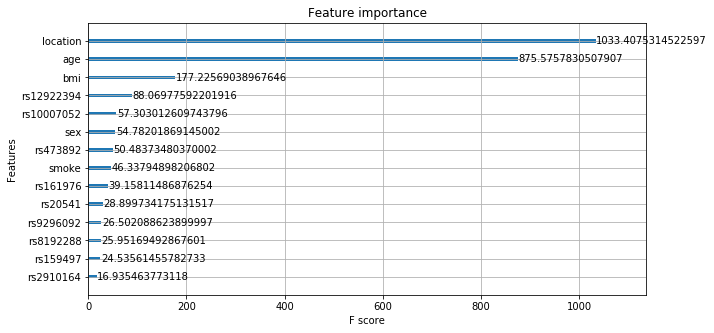

In [48]:
###基础模型查看特征重要性,依据不同的评价标准用于选择特征 这里使用Total_gain作为特征重要性选择的标准####
from matplotlib import pyplot
import seaborn as sns
from xgboost import plot_importance
model = xgboost
#train_x.columns = feature_list
train_x,train_y = load_data(data)
model.fit(train_x,train_y)
fig = plot_importance(model,importance_type="total_gain",show_values=True).get_figure()
#fig = plot_importance(model,show_values=False).get_figure()
fig.set_size_inches(10,5)
fig.savefig("./result_1024/feature_importance_have_value.tiff",dpi=200)
fig.show()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: \n' % importance_type, model.get_booster().get_score(importance_type=importance_type),"\n")

# plot ROC curve

In [77]:
feature,target = load_data(data)
X,y=np.array(feature),np.array(target)
print(X.shape,y.shape)
cv = StratifiedKFold(n_splits=5,random_state=1)

(393, 9) (393,)


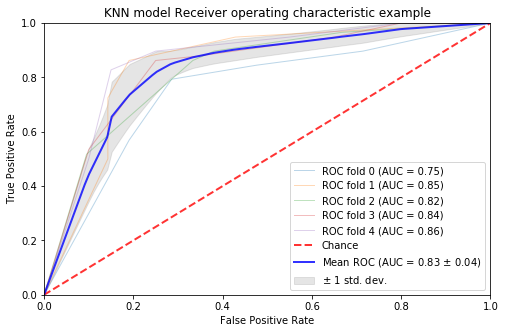

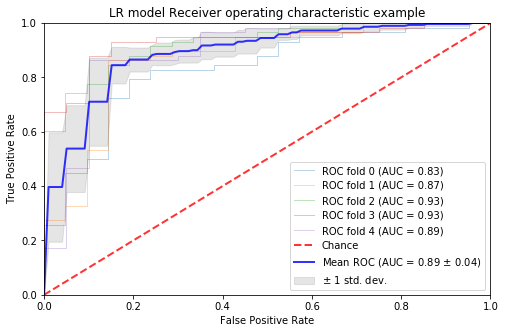

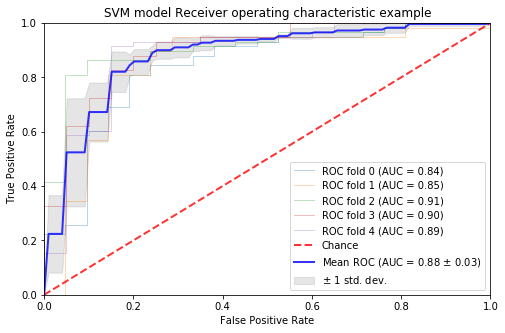

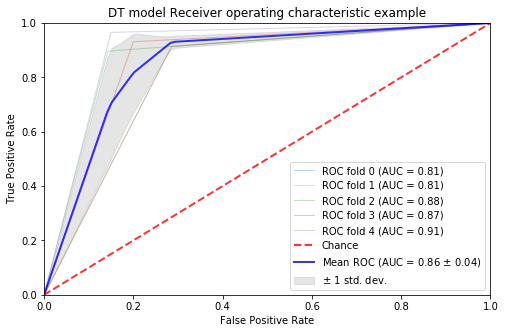

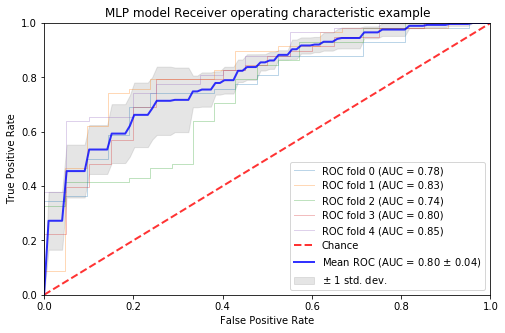

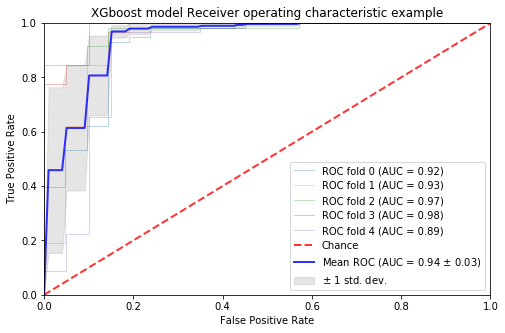

In [50]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

def plot_ROC(model,model_name):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    fig=plt.gcf()
    fig.set_size_inches(8,5)

    for train, test in cv.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1]) #,pos_label=1
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.0, 1.0])
    plt.ylim([-0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} model Receiver operating characteristic example'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()
    
for model,model_name in zip(classifier_lst,classifier_lst_name):
    plot_ROC(model,model_name)

roc_auc_CI (0.4366954022988506, 0.6977832512315271)
roc_auc_CI (0.6101806239737274, 0.7178017241379311)
roc_auc_CI (0.50185960591133, 0.6708477011494253)
roc_auc_CI (0.4447557471264368, 0.5969827586206896)
roc_auc_CI (0.5639408866995076, 0.6943493431855501)
roc_auc_CI (0.503091133004926, 0.6207491789819377)


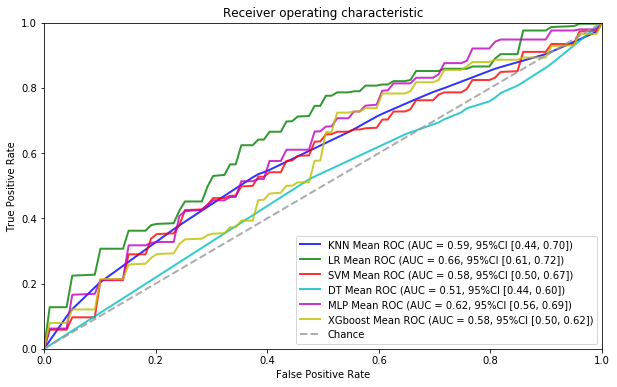

In [78]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

def plot_ROC(model,model_name,color):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1]) #,pos_label=1
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    roc_auc_CI = np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)
    print("roc_auc_CI",roc_auc_CI)
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=r'{} Mean ROC (AUC = %0.2f, 95%%CI [%0.2f, %0.2f])'.format(model_name) % (mean_auc, roc_auc_CI[0], roc_auc_CI[1]),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

color_list = ['b','g','r','c','m','y']
fig=plt.gcf()
fig.set_size_inches(10,6)
for model,model_name,color in zip(classifier_lst,classifier_lst_name,color_list):
    plot_ROC(model,model_name,color)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color=(0.6, 0.6, 0.6),label='Chance', alpha=.8)
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
fig.show()
fig.savefig('result_1024/all_feature/allfeature_allModel_5fold_avgtrain ROC curve_2.png',dpi=200)
#fig.savefig('result_1024/clincal/clinic_allModel_5fold_avgtrain ROC curve_2.png',dpi=200)
#fig.savefig('result_1024/feature_snp/snp_allModel_5fold_avgtrain ROC curve_2.png',dpi=200)

# plot PRC Curve
- fpr = recall
- tpr = precision

prc_auc_CI (0.7482432101669295, 0.8768059347716156)
prc_auc_CI (0.7908937380782413, 0.892474180048166)
prc_auc_CI (0.7116652760269567, 0.8381921752937258)
prc_auc_CI (0.8017029316954014, 0.8398396141962882)
prc_auc_CI (0.7457929803285975, 0.870372994363843)
prc_auc_CI (0.7537912250316156, 0.8187892010575554)


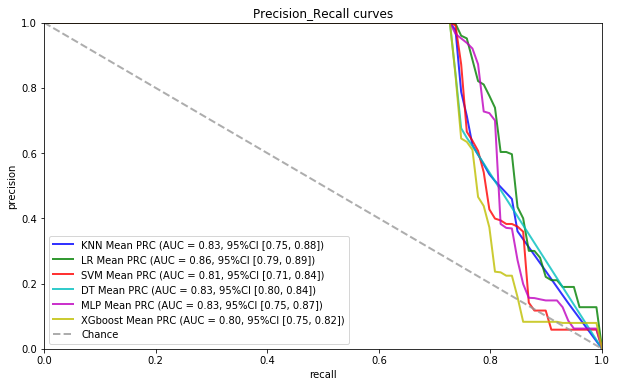

In [79]:
from sklearn.metrics import roc_curve, auc,roc_auc_score,precision_recall_curve
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

def plot_ROC(model,model_name,color):
    recalls = []
    precisions = []
    aucspr = []
    mean_recall = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):

        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        #recall, precision, thresholds = roc_curve(y[test], probas_[:, 1]) #,pos_label=1
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        precisions.append(interp(mean_recall, precision,recall))
        pr_auc = auc(recall, precision)
        aucspr.append(pr_auc)
        i += 1
    mean_precision = np.mean(precisions,axis = 0)
    #print(mean_precision)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucspr)
    prc_auc_CI = np.percentile(aucspr, 2.5), np.percentile(aucspr, 97.5)
    print("prc_auc_CI",prc_auc_CI)
    
    plt.plot(mean_recall, mean_precision, color=color,
             label=r'{} Mean PRC (AUC = %0.2f, 95%%CI [%0.2f, %0.2f])'.format(model_name)% (mean_auc,prc_auc_CI[0], prc_auc_CI[1]),
             lw=2, alpha=.8)

color_list = ['b','g','r','c','m','y']
fig=plt.gcf()
fig.set_size_inches(10,6)
for model,model_name,color in zip(classifier_lst,classifier_lst_name,color_list):
    plot_ROC(model,model_name,color)
    
x1 = np.linspace(0,1,100)
y1 = -1*x1+1
plt.plot(x1,y1, linestyle='--', lw=2, color=(0.6, 0.6, 0.6),label='Chance', alpha=.8)
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision_Recall curves')
plt.legend(loc="lower left")
fig.show()
fig.savefig('result_1024/all_feature/all_feature_allModel_5fold_avg_train PR curve_2.png',dpi=200) # 保存 所有特征
#fig.savefig('result_1024/clincal/clinic_allModel_5fold_avg_train PR curve_2.png',dpi=200) #保存clinic特征
#fig.savefig('result_1024/feature_snp/snp_allModel_5fold_avg_train PR curve_2.png',dpi=200) #保存 snp特征